In [1]:
from dataclasses import asdict

import math
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from minitorch.module import Network, Linear
from minitorch.optim import SGDOptimizer
from minitorch.datasets import Datasets, DatasetTypes
from minitorch.operators import sigmoid

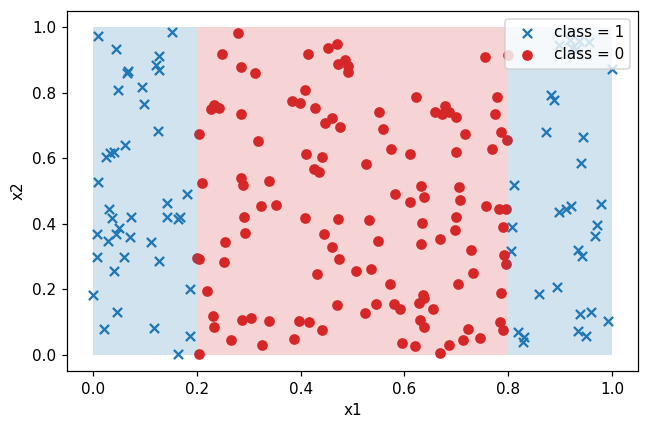

In [2]:
# Create a dataset
dataset_type = DatasetTypes.split

datasets = Datasets.generate_datasets(n_samples=200)
dataset = asdict(datasets)[dataset_type]

pos_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 1]
neg_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 0]

x1_pos, x2_pos = zip(*pos_class)
x1_neg, x2_neg = zip(*neg_class)

fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue", label="class = 1")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red", label="class = 0")
ax.legend(loc=1)

left = Rectangle((0.0, 0.0), 0.2, 1.0, color="tab:blue", alpha=0.2, lw=0.0)
center = Rectangle((0.2, 0.0), 0.6, 1.0, color="tab:red", alpha=0.2, lw=0.0)
right = Rectangle((0.8, 0.0), 0.2, 1.0, color="tab:blue", alpha=0.2, lw=0.0)

ax.add_patch(left)
ax.add_patch(center)
ax.add_patch(right)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

In [3]:
# Create linear layer
linear = Linear(2, 1)

# Create a network
network = Network(input_dim=2, hidden_dim=5, output_dim=1)

In [4]:
# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.3)

In [5]:
# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [6]:
# Training loop
n_epochs = 100
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X)

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]

    # Compute a loss
    loss_per_epoch = 0
    for i in range(len(y_true)):
        loss_per_epoch += (y_hat[i][0].log() if y_true[i] == 1.0 else (- y_hat[i][0] + 1).log())
    loss_per_epoch = (- loss_per_epoch / len(y_true))
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

epoch 0: loss = 1.0109923764074011
epoch 10: loss = 0.6718176341949896
epoch 20: loss = 0.66403880104903
epoch 30: loss = 0.6635586421459359
epoch 40: loss = 0.6632607289001029
epoch 50: loss = 0.662977313039097
epoch 60: loss = 0.6627035921936875
epoch 70: loss = 0.6624388621239072
epoch 80: loss = 0.6621825706095573
epoch 90: loss = 0.6619342142085018


In [15]:
y_hat = network.forward(X)
y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
y_hat_classes = [[1 if proba.data >= 0.5 else 0 for proba in row] for row in y_hat]
y_hat_classes = list(itertools.chain.from_iterable(y_hat_classes))

In [16]:
# Accuraccy
sum(
    [
        1 if y_hat_c == y_true_c 
        else 0 for (y_hat_c, y_true_c) in zip(y_hat_classes, y_true)
    ]
) / len(y_true)

0.625

In [18]:
sum(y_true) / len(y_true)

0.375

In [ ]:
# Visualising predictions
fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

# Visualise decision boundaries

bias_positions = list(np.linspace(0, 2, 51))
x_range = list(np.linspace(0, 1, 51))

for bias_lower, bias_upper in zip(bias_positions, bias_positions[1:]):
    
    # Create corresponding x2 values for lower
    X_lower = [list((x1, bias_lower - x1)) for x1 in x_range]
    
    # Clamp values to between 0.0 and 1.0
    X_lower = [[x1, max(min(x2, 1.0), 0.0)] for (x1, x2) in X_lower]
    y_lower = linear.forward(X_lower)
    y_mean_lower = sigmoid(sum(scalar[0].data for scalar in y_lower) / len(y_lower))

    # Create corresponding x2 values for upper
    X_upper = [list((x1, bias_upper - x1)) for x1 in x_range]
    
    # Clamp upper and lower bounds
    X_upper = [[x1, max(min(x2, 1.0), 0.0)] for (x1, x2) in X_upper]
    y_upper = linear.forward(X_upper)
    y_mean_upper = sigmoid(sum(scalar[0].data for scalar in y_upper) / len(y_upper))

    # Plot and fill    
    ax.fill_between(
        x_range,
        [x2 for (_, x2) in X_lower],
        [x2 for (_, x2) in X_upper],
        alpha=(y_mean_lower - 0.5) if y_mean_lower >= 0.5 else (0.5 - y_mean_lower),
        color="tab:blue" if y_mean_lower >= 0.5 else "tab:red",
        lw=0.01
    )
    

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();